In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
from numba import cuda
%matplotlib inline

In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)
    

In [3]:
df = pd.read_csv('../data/Sunspots.csv')

In [4]:
df.head()

,Unnamed: 0,Date,Monthly Mean Total Sunspot Number
0,0,1749-01-31,96.7
1,1,1749-02-28,104.3
2,2,1749-03-31,116.7
3,3,1749-04-30,92.8
4,4,1749-05-31,141.7


In [6]:
sunspots = np.array(df["Monthly Mean Total Sunspot Number"])
time = df["Unnamed: 0"]

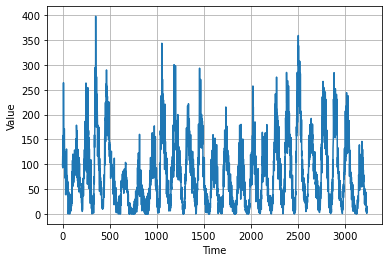

In [7]:
plot_series(time,sunspots)

In [8]:
def windowed_dataset(series,window_size,batch_size,shuffle_b_size):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size+1,shift = 1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window : window.batch(window_size+1))
    dataset = dataset.shuffle(shuffle_b_size).map(lambda window : (window[:-1],window[1:]))
    return dataset.batch(batch_size).prefetch(1)

In [9]:
def model_forecast(model,series,window_size,batch_size):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size,shift = 1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window : window.batch(window_size))
    dataset.batch(batch_size).prefetch(1)
    forecast = model.predict(dataset)
    return forecast
   

In [10]:
window_size = 30
batch_size = 32
shuffle_buffer_size = 1000 
split_time = 2500

x_train = sunspots[:split_time]
time_train = time[:split_time]

x_valid = sunspots[split_time:]
time_valid = sunspots[split_time:]



In [11]:
dataset_final = windowed_dataset(x_train,window_size,batch_size,shuffle_buffer_size)

In [18]:
tf.keras.backend.clear_session()
cuda.close()

In [12]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(20,activation='relu',input_shape = [window_size] ),
    tf.keras.layers.Dense(10,activation='relu'),
    tf.keras.layers.Dense(1)
])

In [13]:
model.compile(loss = "mse",optimizer = tf.keras.optimizers.SGD(lr = 1e-7,momentum=0.9))
history = model.fit(dataset_final,epochs=100,verbose=0)

In [14]:
forecast=[]
for time_i in range(len(sunspots) - window_size):
    forecast.append(model.predict(sunspots[time_i:time_i+window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))



<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

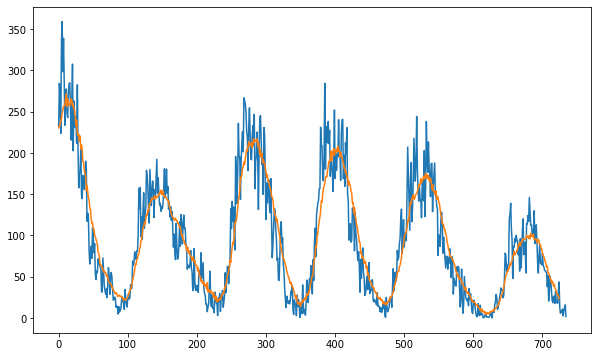

In [20]:
plt.figure(figsize=(10,6))
plt.plot(x_valid)
plt.plot(results[10:])

In [26]:
tf.keras.metrics.mean_absolute_error(x_valid,results).numpy()

39.69093